TODO: continue with the `hoggorm` package to compute the RV coeffs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import typing
from typing import Any, Dict, List, Optional
from typeguard import typechecked
import pickle
import argparse
import scipy
from utils.utils_IO import save_object, load_object
from utils.kinematics import compute_speed, compute_accel
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import hoggorm as ho # library for multivariate stats

In [2]:
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/mormyrid-control/mrmrd_ctrl'

In [3]:
data_dict = load_object('/Volumes/sawtell-locker/C1/free/3d_reconstruction/V2/data_dict')

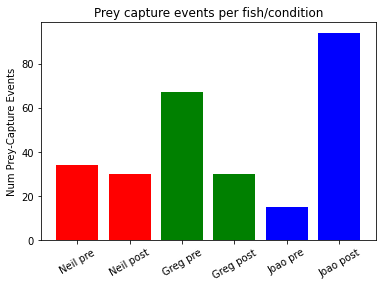

In [4]:
count = 0
color_list = ['r', 'g', 'b']
xlabel_list = []
for i, name in enumerate(data_dict["inds"].keys()):
    for j, cond in enumerate(data_dict["inds"][name].keys()):
        plt.bar(count, len(data_dict["inds"][name][cond]), color = color_list[i])
        count+=1
        xlabel_list.append(name + ' ' + cond)
plt.xticks(ticks=np.arange(count), labels = xlabel_list, rotation=30);
plt.ylabel("Num Prey-Capture Events");
plt.title('Prey capture events per fish/condition');

In [5]:
def plot_correlation_heatmap(corr_mat: pd.core.frame.DataFrame, labels: list[str])-> None:
    plt.imshow(corr_mat)
    plt.xticks(ticks = np.arange(0, corr_mat.shape[-1], 3), labels =  labels, rotation=40);
    plt.yticks(ticks = np.arange(0, corr_mat.shape[-1], 3), labels =  labels);

## store an array of correlation matrices (pages: number of trials)

In [44]:
@typechecked
def compute_RV_coef(inputs: np.array, outputs: np.ndarray)-> np.ndarray:
    cent_inputs = ho.center(inputs, axis=0)
    cent_outputs = ho.center(outputs, axis=0)
    return ho.RVcoeff([cent_inputs, cent_outputs])

In [6]:
@typechecked
def make_empty_hierarchical_dict(unique_names: list, unique_conds: list)-> dict:
    trial_dict = {}
    for name in unique_names:
        trial_dict[name] = {}
        for cond in unique_conds:
            trial_dict[name][cond] = []
    return trial_dict

In [7]:
@typechecked
def select_columns(dframe: pd.core.frame.DataFrame, names: Optional[list] = None) -> pd.core.frame.DataFrame:
    '''problem here is that is that the column names are unchanged...'''
    if names is None:
        names = list(dframe.columns.levels[0][1:-5])
    return dframe[names]

In [15]:
@typechecked
def fish_dict_to_dframe(hier_dict: dict) -> pd.core.frame.DataFrame:
    dframe_dict = pd.DataFrame(columns= ["Fish", "Lesion", "Variable"])
    for i, fish in enumerate(hier_dict.keys()):
        for j, cond in enumerate(hier_dict[fish].keys()):
            for k, var in enumerate(hier_dict[fish][cond]):
                dframe_dict = dframe_dict.append({"Fish": fish, 
                                "Lesion": cond, 
                                "Variable": var}, ignore_index=True)
    return dframe_dict

In [8]:
col_order = ['tail', 'caudal_d', 'caudal_v', 'mid', 'head', 'chin_base', 'chin_1_4', 'chin_mid', 'chin_3_4','chin_end']

In [9]:
corr_dict = make_empty_hierarchical_dict(list(data_dict["trials"].keys()) ,list(data_dict["trials"]["Joao"].keys()))
for i, fish in enumerate(data_dict["trials"].keys()):
    for j, cond in enumerate(data_dict["trials"][fish].keys()):
        corr_dict[fish][cond] = np.zeros((30, 30, len(data_dict["trials"][fish][cond])))
        for k, trial_dframe in enumerate(data_dict["trials"][fish][cond]):
            curr_dframe = select_columns(trial_dframe)
            curr_dframe = curr_dframe[col_order] # re-order columns to emphasize chin pos
            corr_dict[fish][cond][:,:,k] = curr_dframe.corr()

In [10]:
trial_dframe.columns.levels[0][1:-5]

Index(['caudal_d', 'caudal_v', 'chin_1_4', 'chin_3_4', 'chin_base', 'chin_end',
       'chin_mid', 'head', 'mid', 'tail'],
      dtype='object')

## should we or shouldn't we use absolute value for the corrs?

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

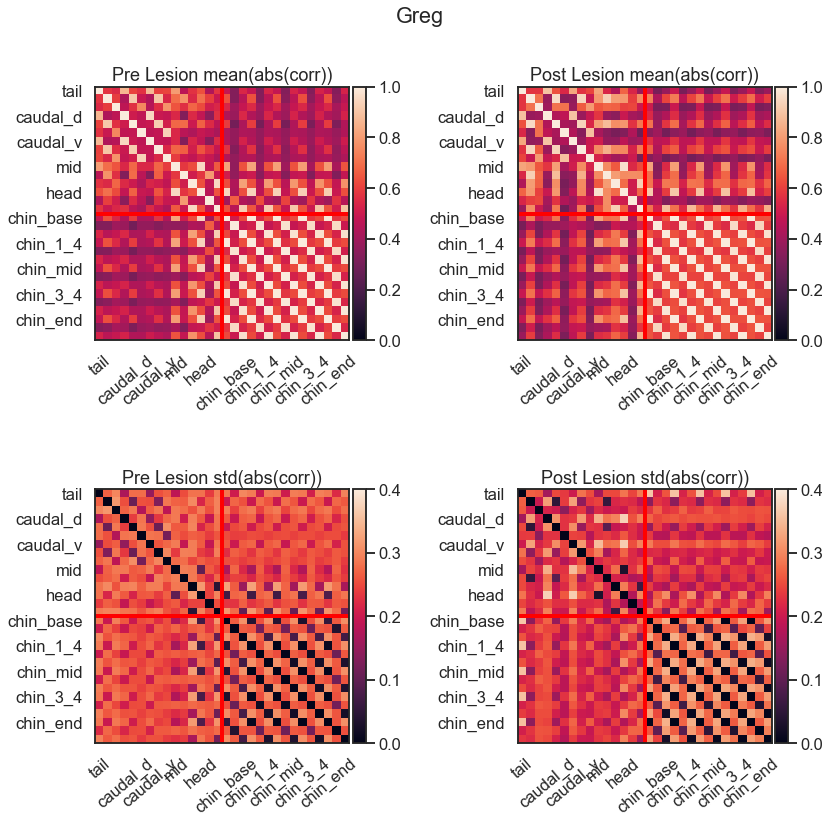

In [12]:
sns.set_style("white")
sns.set_context("talk")

fish_name = "Greg"
fig, ax = plt.subplots(2,2, figsize = (12,12))
im = ax[0,0].imshow(np.nanmean(np.abs(corr_dict[fish_name]["pre"]), -1), vmin=0, vmax=1)
ax[0,0].set_title('Pre Lesion mean(abs(corr))')
im1 = ax[0,1].imshow(np.nanmean(np.abs(corr_dict[fish_name]["post"]), -1), vmin=0, vmax=1)
ax[0,1].set_title('Post Lesion mean(abs(corr))')
im2 = ax[1,0].imshow(np.nanstd(np.abs(corr_dict[fish_name]["pre"]), -1), vmin=0, vmax=.4)
ax[1,0].set_title('Pre Lesion std(abs(corr))')
im3 = ax[1,1].imshow(np.nanstd(np.abs(corr_dict[fish_name]["post"]), -1), vmin=0, vmax=.4)
ax[1,1].set_title('Post Lesion std(abs(corr))')

ax = ax.flatten()
ims = [im, im1, im2, im3]
for i, curr_ax in enumerate(ax):
    divider = make_axes_locatable(curr_ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    curr_ax.set_xticks(ticks = np.arange(0, 30, 3));
    curr_ax.set_xticklabels(labels =  col_order, rotation=40)
    curr_ax.set_yticks(ticks = np.arange(0, 30, 3));
    curr_ax.set_yticklabels(labels =  col_order)
    #rect = patches.Rectangle((15-1.5,15-1.5), 15+1, 15+1, color = 'red', fill=False, linewidth=4)
    #curr_ax.add_patch(rect)
    curr_ax.plot([0-.5, 30-1+.5], [15-.5, 15-.5], linewidth=4, color='red')
    curr_ax.plot([15-.5, 15-.5], [0-.5, 30-1+.5], linewidth=4, color='red')
    fig.colorbar(ims[i], cax=cax, orientation='vertical')
    
fig.suptitle(fish_name)
fig.tight_layout()
plt.savefig('first_pass_corrs_%s.png' % fish_name)


let zero-mean variables:
$$
X \in \mathbb{R}^{K \times T} \\
Y \in \mathbb{R}^{L \times T} \\ 
$$
linear regression
$$
Y = \beta X + \epsilon, \quad \beta \in \mathbb{R}^{L \times K} \\
YX^T = \beta XX^T \\ 
\beta = YX^T(XX^T)^{-1}
$$
idea --> fit a linear model from all bodyparts other than the chin, to all bodyparts including the chin. do it per trial. look at the matrices.

### want:
* for every trial, predict chin using non-chin, save coeffs, compute r squared, and save. 
## Thoughts:
* we compare between two sets of vectors in MV stats
* here' specifically, we're interested in correlations between chin and rest of body, and how they change in each condition.
* stats: compute some covariance or correlation matrix per trial
* then, compute a correlation between a pair of matrices (RV coeff)
* then do hypothesis testing on the RV coeff

In [13]:
data_dict.keys()

dict_keys(['trials', 'inds', 'points_3d_paths', 'video_paths'])

In [57]:
body_part_for_kinematics = "mid"
center_coords = True
if center_coords:
    fit_intercept = False
fish_names = list(data_dict["trials"].keys())
cond_names = list(data_dict["trials"]["Joao"].keys())
beta_dict = make_empty_hierarchical_dict(fish_names, cond_names)
r_squared_dict = make_empty_hierarchical_dict(fish_names, cond_names)
rv_dict = make_empty_hierarchical_dict(fish_names, cond_names)
speed_dict = make_empty_hierarchical_dict(fish_names, cond_names)
accel_dict = make_empty_hierarchical_dict(fish_names, cond_names)

for i, fish in enumerate(data_dict["trials"].keys()):
    for j, cond in enumerate(data_dict["trials"][fish].keys()):
        #beta_dict[fish][cond] = np.zeros((15, 15, len(data_dict["trials"][fish][cond])))
        for k, trial_dframe in enumerate(data_dict["trials"][fish][cond]):
            curr_dframe = select_columns(trial_dframe)
            if center_coords:
                curr_dframe -= curr_dframe.mean()
            curr_dframe = curr_dframe[col_order] # re-order columns to emphasize chin pos
            inputs = curr_dframe.iloc[:, :15].to_numpy() # body coords
            outputs = curr_dframe.iloc[:, 15:].to_numpy() # chin coords
            reg = LinearRegression(fit_intercept=fit_intercept).fit(inputs,outputs) # the intercept is helpful for better preds
            r_squared = reg.score(inputs, outputs)
            rv = compute_RV_coef(inputs, outputs)
            # save
            r_squared_dict[fish][cond].append(r_squared)
            rv_dict[fish][cond].append(rv[0,1])
            beta_dict[fish][cond].append(reg.coef_)
            speed_dict[fish][cond].append(compute_speed(curr_dframe[body_part_for_kinematics], 300).mean().mean())
            accel_dict[fish][cond].append(compute_accel(curr_dframe[body_part_for_kinematics], 300).mean().mean())

In [58]:
accel_dframe = fish_dict_to_dframe(accel_dict)

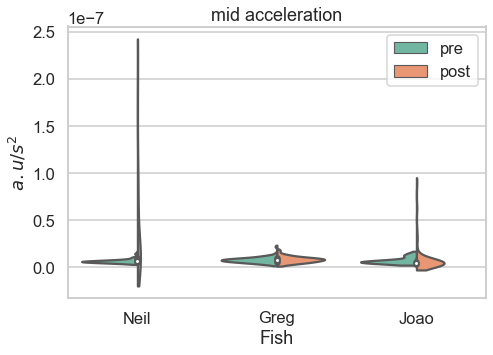

In [59]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize = (7.5,5))
sns.violinplot(x="Fish", y="Variable", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=accel_dframe, z_order=1)
plt.title("%s acceleration" % body_part_for_kinematics);
plt.ylabel(r'$a.u/s^2$');
plt.legend(loc = "upper right")
plt.savefig('%s_accel.png' % body_part_for_kinematics)

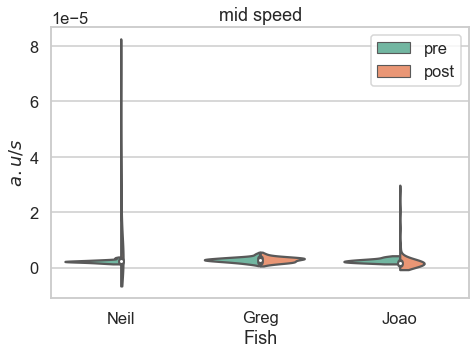

In [60]:
speed_dframe = fish_dict_to_dframe(speed_dict)
plt.figure(figsize = (7.5,5))
sns.set_style("whitegrid")
sns.set_context("talk")
sns.violinplot(x="Fish", y="Variable", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=speed_dframe, z_order=1)
plt.title("%s speed" % body_part_for_kinematics);
plt.ylabel(r'$a.u/s$');
plt.legend(loc = "upper right")
plt.savefig('%s_speed.png' % body_part_for_kinematics)

In [50]:
rv_dframe = fish_dict_to_dframe(rv_dict)
rv_dframe

,Fish,Lesion,Variable
0,Neil,pre,0.838141
1,Neil,pre,0.813645
2,Neil,pre,0.507686
3,Neil,pre,0.661025
4,Neil,pre,0.382948
...,...,...,...
265,Joao,post,0.978599
266,Joao,post,0.853102
267,Joao,post,0.915154
268,Joao,post,0.912040


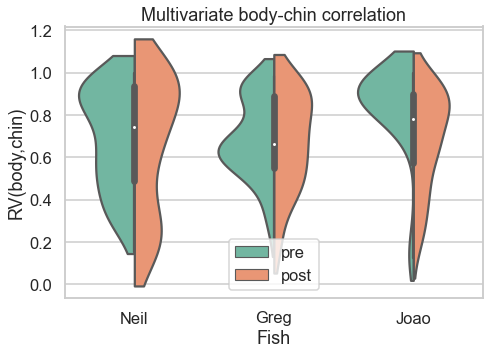

In [54]:
sns.set_style("whitegrid")
sns.set_context("talk")
plt.figure(figsize = (7.5,5))
sns.violinplot(x="Fish", y="Variable", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=rv_dframe, z_order=1)
plt.title("Multivariate body-chin correlation");
plt.ylabel("RV(body,chin)");
plt.legend(loc = "lower center")
plt.savefig('RV.png' )

In [27]:
# want: column called name, column called condition, and column called r_squared
dframe_dict = pd.DataFrame(columns= ["Fish", "Lesion", "r_squared"])

dframe_dict.head()
for i, fish in enumerate(r_squared_dict.keys()):
    for j, cond in enumerate(r_squared_dict[fish].keys()):
        for k, r_sq in enumerate(r_squared_dict[fish][cond]):
            dframe_dict = dframe_dict.append({"Fish": fish, 
                            "Lesion": cond, 
                            "r_squared": r_sq}, ignore_index=True)
assert(np.max(dframe_dict["r_squared"])<1.0)

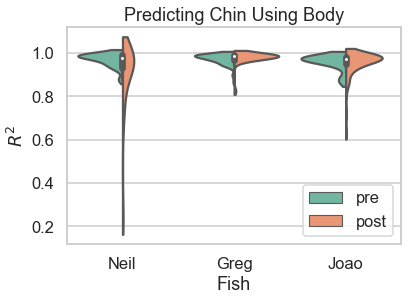

In [28]:
sns.set_style("whitegrid")
sns.set_context("talk")
sns.violinplot(x="Fish", y="r_squared", hue = "Lesion", palette = "Set2", split = True, cut = 1., data=dframe_dict, z_order=1)
plt.title("Predicting Chin Using Body");
plt.ylabel(r'$R^2$');
plt.legend(loc = "lower right")
plt.savefig('r_squared.png')

In [37]:
cent_inputs = ho.center(inputs, axis=0)
cent_outputs = ho.center(outputs, axis=0)

In [36]:
(np.abs(cent_inputs.mean(axis=0)-0.0)<10**(-6)).all()

True

In [39]:
rv_results_cent = ho.RVcoeff([cent_inputs, cent_outputs])
print(rv_results_cent)
print(type(rv_results_cent))

[[1.         0.99982447]
 [0.99982447 1.        ]]
<class 'numpy.ndarray'>


In [43]:
compute_RV_coef(inputs, outputs)

array([[1.        , 0.99982447],
       [0.99982447, 1.        ]])